# Figures Article Guidelines for Dynamical Perturbation Network

## Imports

In [1]:
from os.path import join as jn
import networkx as nx
import numpy as np
import scipy
from tabulate import tabulate
import matplotlib.pyplot as plt
import matplotlib as mpl
import itertools
import re
from Bio.PDB.Polypeptide import aa1, aa3
import seaborn as sns
import pandas as pd

mpl.style.use('classic')
%matplotlib inline

three2one = dict(zip(aa3,aa1))

## Loading Data

In [2]:
results_folder = '/home/aria/landslide/RESULTS/GUIDELINES/'
L_cutoffs = list(range(3,10))

def get_net_list(string):
    paths = [jn(results_folder, string, "cutoff%s", '0.p') % i for i in L_cutoffs]
    return {i: nx.read_gpickle(path) for i, path in zip(L_cutoffs, paths)}   
titles = ['FULL', 'FULLH', 'BACKBONE', 'BACKBONEH', 'SIDECHAIN', 'SIDECHAINH']
full, fullH, backbone, backboneH, sidechain, sidechainH = [get_net_list(string) for string in titles]
L_dict_net = [full, fullH, backbone, backboneH, sidechain, sidechainH]


## Definition of types of contact

In [3]:
tuple_residues = [(['R', 'K'], '+'),
                (['D', 'E'], '-'),
                (['S', 'T', 'N', 'Q', 'Y', 'H'], 'p'),
                (['I', 'L', 'V', 'M', 'F', 'W', 'C', 'P', 'G', 'A'], 'h')]

dict_interactions = {('+', '-'): 'salt_bridge',
                    ('-', '+'): 'salt_bridge',
                    ('+', '+'): 'same_charge',
                    ('-', '-'): 'same_charge',
                    ('h', 'h'): 'hydrophobic',
                    ('p', 'p'): 'polar'
}
L_interactions = ['salt_bridge', 'same_charge', 'hydrophobic', 'polar', 'non-specific', 'covalent']

dict_residues = {}
for tup in tuple_residues:
    for elt in tup[0]:
        dict_residues[elt] = tup[1]
        
def get_toi(u, v):
    toi = (dict_residues[u[0]] , dict_residues[v[0]])
    if abs(int(u[1:-2])-int(v[1:-2])) == 1:
        return 'covalent' 
    elif toi in dict_interactions:
        return dict_interactions[toi]
    else:
        return 'non-specific'
    
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
toi2colors = dict(zip(L_interactions, colors))
print(toi2colors)

{'salt_bridge': 'b', 'same_charge': 'g', 'hydrophobic': 'r', 'polar': 'c', 'non-specific': 'm', 'covalent': 'y'}


## Figure 1 / Table 1

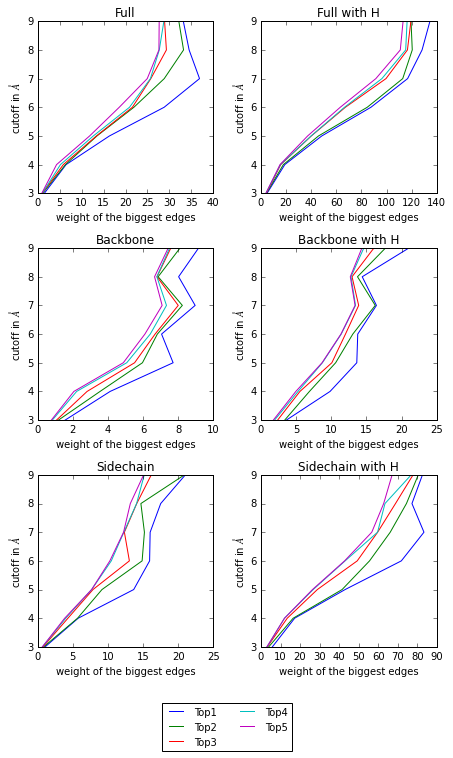

In [4]:
def plot_top_contacts(k, dict_net, ax):
    table = np.zeros((7, k))
    for i, j in enumerate(L_cutoffs):
        net = dict_net[j]
        topk = sorted(net.edges(data=True), key = lambda x: x[2]['weight'], reverse=True)[:k]
        table[i] = [topk[i][2]['weight'] for i in range(k)]
        
    index = ['Top%s' % str(i+1) for i in range(0,k)]
#    print(tabulate(np.transpose(table), headers=L_cutoffs, showindex = index,
#                  tablefmt="latex", floatfmt=".2f"))

#    fig = plt.figure()
    for i, j in enumerate(index):
        ax.plot(table[:,i], L_cutoffs, label=j)
    ax.set_ylabel('cutoff in $\AA$')
    ax.set_xlabel('weight of the biggest edges')

# fig, axs = plt.subplots(3, 2, sharex=True, sharey=True)
fig, axs = plt.subplots(3, 2, figsize=[6.4, 9.6])

for dict_net, title, ax in zip(L_dict_net, titles, axs.reshape(-1)):
    ax.set_title(re.sub(r"h$", " with H", title.capitalize()))
    plot_top_contacts(5, dict_net, ax)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.1), prop={'size': 10}, ncol=2)
plt.tight_layout()
plt.show()
plt.close(fig) 
    
    
#    plt.gca().legend(loc='upper left')
#plt.show()
#plt.close()

## Insights:
Here we report the weight of the top5 edges for each perturbation network in function of the cut-off used.

The weights of the biggest edges starts by increasing in each case with the cutoff but after cutoff ~7 Å they reach some sort of plateau. This means that past this cutoff of 7 Å, there's some cancellation of perturbations due to the high cut-off. There's a strong possibility that this effect is already present at lower cut-off values but at 7 Å it becomes critical. For this reason I would not recommand using a cut-off bigger than 7 Å if the goal is to have an overview of all perturbations.

## Figure SI1 ?

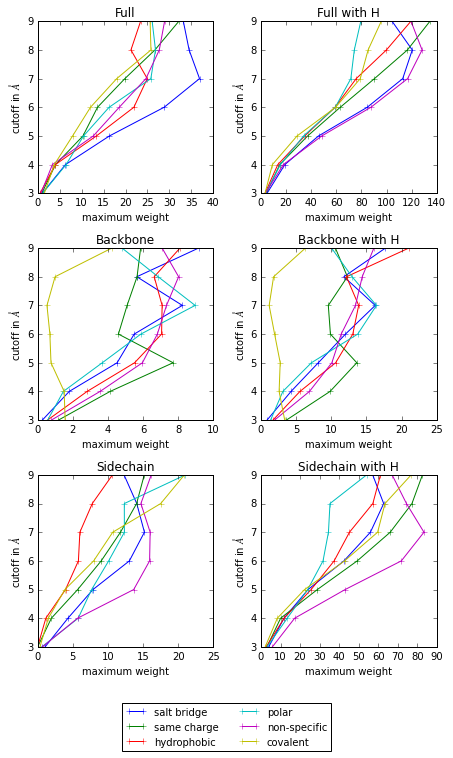

In [5]:
def plot_cut_interaction(dict_net, ax):
    for toi in L_interactions:
        X = np.zeros(7)
        for i, j in enumerate(L_cutoffs):
            net = dict_net[j]
            edges_weight = [net[u][v]['weight'] for u, v in net.edges() if get_toi(u, v) == toi]
            X[i] = np.max(edges_weight)
        ax.plot(X, L_cutoffs, marker='+', label=toi.replace('_', ' '))
        ax.set_xlabel('maximum weight')
        ax.set_ylabel('cutoff in $\AA$')

fig, axs = plt.subplots(3, 2, figsize=[6.4, 9.6])

for dict_net, title, ax in zip(L_dict_net, titles, axs.reshape(-1)):
    ax.set_title(re.sub(r"h$", " with H", title.capitalize()))
    plot_cut_interaction(dict_net, ax)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.1), prop={'size': 10}, ncol=2)
plt.tight_layout()
plt.show()
plt.close(fig)

## Insights:
Here we report the value of the maximum weight for each type of interaction in function of the cut-off for the different perturbation networks.

We have here an idea of "what threshold we need to get rid of a certain type of interaction". 
If we want to get rid of covalent interaction: best to use backbone.
"" non-specific interactions: best to use full network without hydrogens.

I'd like not to rely too much on this graph since it displays only the max value.

## Figure 2

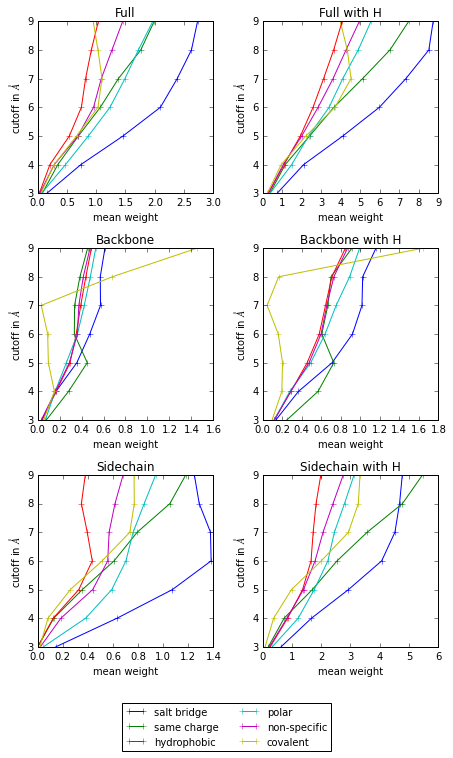

In [6]:
def plot_mean_interaction(dict_net, ax):
    for toi in L_interactions:
        X = np.zeros(7)
        for i, j in enumerate(L_cutoffs):
            net = dict_net[j]
            edges_weight = [net[u][v]['weight'] for u, v in net.edges() if get_toi(u, v) == toi]
            X[i] = np.mean(edges_weight)
        ax.plot(X, L_cutoffs, marker='+', label=toi.replace('_', ' '))
        ax.set_xlabel('mean weight')
        ax.set_ylabel('cutoff in $\AA$')

fig, axs = plt.subplots(3, 2, figsize=[6.4, 9.6])

for dict_net, title, ax in zip(L_dict_net, titles, axs.reshape(-1)):
    ax.set_title(re.sub(r"h$", " with H", title.capitalize()))
    plot_mean_interaction(dict_net, ax)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.1), prop={'size': 10}, ncol=2)
plt.tight_layout()
plt.show()
plt.close(fig)

## Insights:
Here we report the value of the mean weight for each type of interaction in function of the cut-off for the different perturbation networks.

Salt-bridge: Always one of the biggest mean whatever the cutoff and the selection. These interactions are always easy to spot. Starts plateau-ing after cut-off ~7 Å meaning we don't really need to go further than this cut-off to spot them.

Same charge: Steadily increases until 9 Å except for backbone. If we want to spot them it's better to use full/sidechain with or without H in this order: Full < Sidechain ~< FullH < SidechainH and at relatively high cut-off (7-9 Å). Consistent with the fact that they probably represent non-direct contact.


Hydrophobic: Adding H seems to slightly help in each case, but with this definition of contact, these restrictions etc... Not easily spottable.

Polar: Best to use a network without hydrogens and sidechain or full. Best to use a cutoff below 6/7 Å.

Non-specific: similar to hydrophobic except adding/removing H has little influence.

Covalent: Almost non-existent in backbone below 7 Å but then the highest for cutoff 8 and 9. This means a great deal of non-direct perturbations for covalent residues involve backbone elements.

## Figure SI2 ?

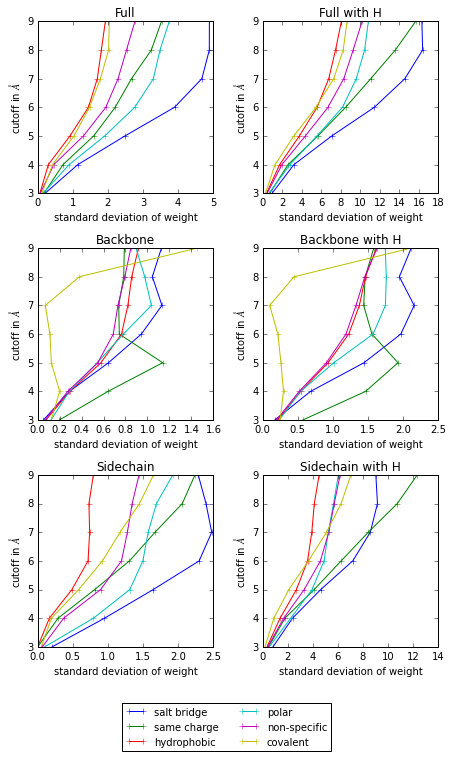

In [7]:
def plot_std_interaction(dict_net, ax):
    for toi in L_interactions:
        X = np.zeros(7)
        for i, j in enumerate(L_cutoffs):
            net = dict_net[j]
            edges_weight = [net[u][v]['weight'] for u, v in net.edges() if get_toi(u, v) == toi]
            X[i] = np.std(edges_weight)
        ax.plot(X, L_cutoffs, marker='+', label=toi.replace('_', ' '))
        ax.set_xlabel('standard deviation of weight')
        ax.set_ylabel('cutoff in $\AA$')

fig, axs = plt.subplots(3, 2, figsize=[6.4, 9.6])

for dict_net, title, ax in zip(L_dict_net, titles, axs.reshape(-1)):
    ax.set_title(re.sub(r"h$", " with H", title.capitalize()))
    plot_std_interaction(dict_net, ax)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.1), prop={'size': 10}, ncol=2)
plt.tight_layout()
plt.show()
plt.close(fig)

## Insights:
I think it's good to also put it in the SI to show that the evolution of the mean is very similar to the evolutions of the std. I'm not 100% sure what that means but I think this can help prove that comparing the mean has some sense.

## Figure 3

/home/aria/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/aria/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


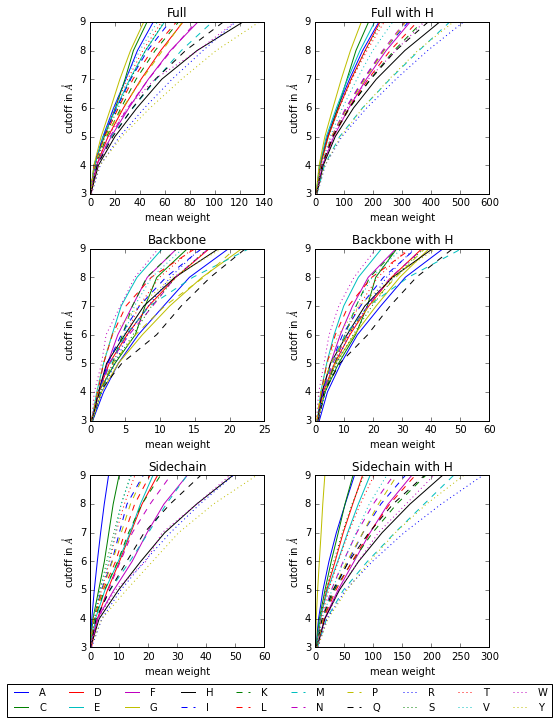

In [8]:
linestyles = itertools.cycle(['solid', 'dashed', 'dotted'])

def plot_mean_aa(dict_net, ax):
    for c, aa in enumerate(aa1):
        if c%7==0:
            linestyle = next(linestyles)
        X = np.zeros(7)
        for i, j in enumerate(L_cutoffs):
            net = dict_net[j]
            weights = [weight for node, weight in net.degree(weight='weight') if node[0]==aa]
#            nodes = [net[u] for u in net.nodes() if u[0] == aa]
#            weights = []
#            for node in nodes:
#                weight = 0
#                for neighbor in node:
#                    weight+=node[neighbor]['weight']  
#                weights.append(weight)
            X[i] = np.mean(np.array(weights))
        ax.plot(X, L_cutoffs, label=aa, linestyle=linestyle)
        ax.set_xlabel('mean weight')
        ax.set_ylabel('cutoff in $\AA$')

fig, axs = plt.subplots(3, 2, figsize=[6.4, 9.6])

for dict_net, title, ax in zip(L_dict_net, titles, axs.reshape(-1)):
    ax.set_title(re.sub(r"h$", " with H", title.capitalize()))
    plot_mean_aa(dict_net, ax)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), prop={'size': 10}, ncol=10)
plt.tight_layout()
plt.show()
plt.close(fig)

## Insights:

Here we report the value of the mean weight for each type of residue in function of the cut-off for the different perturbation networks.

For Full and Backbone with or without H, mean valus are similar until 5 Å. Then becomes really split. For sidechain they split already at the beginning. 
Residues R, H (+ charge): Among the biggest mean weight for full or sidechain network with or without H  at higher cutoffs (consistent with salt bridges). K doesn't show this property... (why? I don't know yet)
Residues Y, W : Also among the biggest for full or sidechain network with or without H. Biggest amino acids so that makes sense.
Residue M: Also among the biggest for full or sidechain with H. A bit less predominant without H. 
Residue G: Smallest for sidechain and full with or without H but one of the biggest for backbone. If we need to spot a G residue: best to use backbone.
Residue P, Q: Kinda average for sidechain/full with or without H but one of the biggest for backbone. I we want to spot P or Q residue: best to use backbone.

=> Most rearrangements of the backbone involve G, P, Q residues
=> Most rearrangements of the sidechains involve R, H, Y, W and M. Maybe we need to moderate this conclusion for Y and W residues because this might only be due to the fact that they are big.


## Attempt at verifying H-bonds

In [9]:
import mdtraj as md

path_apo = '/home/aria/landslide/MDRUNS/IVAN_IGPS/apo_full.dcd'
path_holo = '/home/aria/landslide/MDRUNS/IVAN_IGPS/prfar_full.dcd'
topo = '/home/aria/landslide/MDRUNS/IVAN_IGPS/prot.prmtop'

#traj_apo = md.iterload(path_apo, top=topo, chunk=1000)
#traj_holo = md.iterload(path_holo, top=topo, chunk=1000)
#hbonds_apo = [md.baker_hubbard(t, freq=0.5, periodic=True) for t in traj_apo]
#hbonds_holo = [md.baker_hubbard(t, freq=0.5, periodic=True) for t in traj_holo]
#print(hbonds_apo, hbonds_holo)

traj_apo = md.load(path_apo, top=topo)
traj_holo = md.load(path_holo, top=topo)

def get_hbonds(traj):
    hbonds = md.kabsch_sander(traj)
    c_hbond = {}
    for frame in hbonds:
        id1, id2 = scipy.sparse.find(frame)[:2]
        for u, v in zip(id1, id2):
            if (u, v) in c_hbond:
                c_hbond[(u, v)]+=1
            else:
                c_hbond[(u, v)]=1
    L_hbonds = [hbond for hbond in c_hbond if c_hbond[hbond]>=0.7*len(hbonds)]            
    return L_hbonds

hbonds_apo = get_hbonds(traj_apo)
hbonds_holo = get_hbonds(traj_holo)

broken_hbonds = set(set(hbonds_apo) - set(hbonds_holo)) | set(set(hbonds_holo) - set(hbonds_apo))

condition2chain = {True: ':F', False: ':H'}
label_res = lambda res : three2one[res[:3]]+str(int(res[3:])%253+1)+condition2chain[int(res[3:])<253]
label = lambda hbond : (label_res(str(traj_apo.topology.residue(hbond[0]))), label_res(str(traj_apo.topology.residue(hbond[1]))))
broken_hbonds = [label(hbond) for hbond in broken_hbonds]

## Figure 4

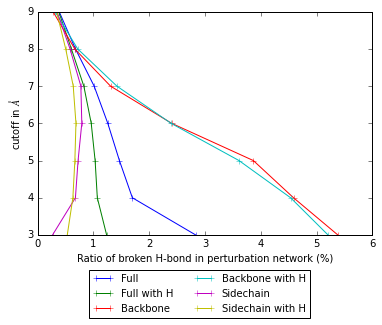

In [10]:
def plot_hbond_perc(dict_net, label): 
    X = np.zeros(7)
    for i, j in enumerate(L_cutoffs):
        net = dict_net[j]
        hbonds_weight = np.sum(np.array([net[u][v]['weight'] for u, v in net.edges() if (u, v) in broken_hbonds or (v, u) in broken_hbonds]))
        total_weight  = np.sum(np.array([weight for node, weight in net.degree(weight='weight')]))
        X[i] = hbonds_weight/total_weight*100
    plt.plot(X, L_cutoffs, marker='+', label=label)

fig = plt.figure()

for dict_net, title in zip(L_dict_net, titles):
    plot_hbond_perc(dict_net, label=re.sub(r"h$", " with H", title.capitalize()))
plt.xlabel('Ratio of broken H-bond in perturbation network (%)')
plt.ylabel('cutoff in $\AA$')
fig.legend(loc='lower center', bbox_to_anchor=(0.5, -0.18), prop={'size': 10}, ncol=2)
plt.show()
plt.close(fig)

## Insights:

The perturbation network is rather effective at detecting H-bonds breaking/forming when studying backbone only (with or without H) and full network. To see backbone hydrogen bonds breaking/forming, the best is to use a small cut-off ~3 Å. For sidechain-sidechain hydrogen bonds, the best is to use a cut-off between 5 and 7 Å.

## Figure 5

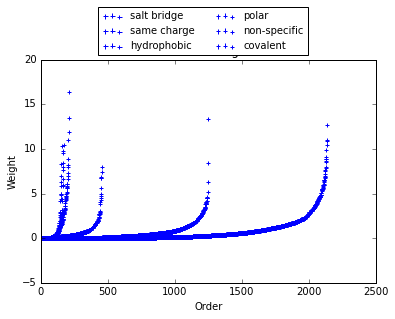

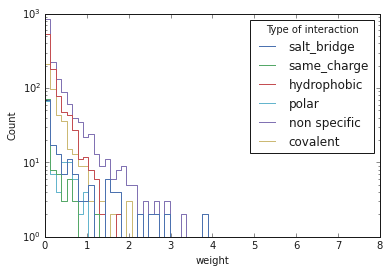

In [11]:
def plot_ordered(net, ax=None):
    if ax == None:
        ax = plt.gca()
    for toi in L_interactions:
        edges_weight = [net[u][v]['weight'] for u, v in net.edges() if get_toi(u, v) == toi]
        ax.scatter(range(len(edges_weight)), np.sort(edges_weight), marker='+', label=toi.replace('_', ' '))
        ax.set_title('Ordered weights')
        ax.set_ylabel('Weight')
        ax.set_xlabel('Order')
        ax.set_xlim(0, 2500)

def plot_distribution(net):
    df = pd.DataFrame(columns=['Type of interaction', 'weight'])
    for toi in L_interactions:
        edges_weight = [net[u][v]['weight'] for u, v in net.edges() if (get_toi(u, v) == toi)]
        _df = pd.DataFrame({'Type of interaction': toi.replace('-', ' '), 'weight': edges_weight})
        df = pd.concat([df, _df])
    sns.set_color_codes()
#    sns.displot(data=df, x='weight', hue='Type of interaction', kind='kde')
#    plt.gca().set_yscale('log')
    plt.gca().set_xlim(0, 8)
    sns.histplot(data=df, x='weight', hue='Type of interaction', element='step', log_scale=[False, True], fill=False, bins=50)
#    sns.ecdfplot(data=df, x='weight', hue='Type of interaction', complementary=True, palette=colors)

fig = plt.figure()
plot_ordered(full[5])
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), prop={'size': 10}, ncol=2)
plt.show()
plt.close(fig)

#plot_distribution(full[5])

plot_distribution(full[4])



## Figure Heatmap

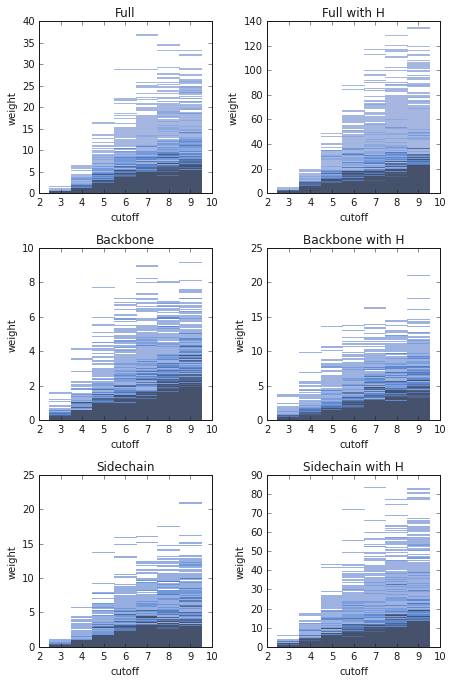

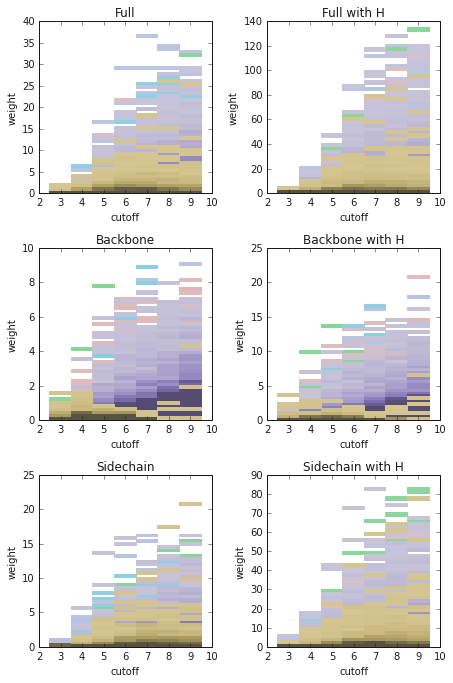

In [12]:
def create_dataframe(dict_net):
    df = pd.DataFrame(columns=['Type of interaction', 'cutoff', 'weight'])
    for cutoff in dict_net:
        net = dict_net[cutoff]
        for toi in L_interactions:
            edges_weight = [net[u][v]['weight'] for u, v in net.edges() if (get_toi(u, v) == toi)]
            _df = pd.DataFrame({'Type of interaction': toi.replace('-', ' '), 'cutoff': cutoff, 'weight': edges_weight})
            df = pd.concat([df, _df])
    return df

#interactions = create_dataframe(full)
#sns.histplot(interactions, x="cutoff", y="weight", discrete=(True, False), pmax=.05) 
#plt.show()
#sns.histplot(interactions, x="cutoff", y="weight", hue='Type of interaction', discrete=(True, False), pmax=.05) 
#plt.show()


fig, axs = plt.subplots(3, 2, figsize=[6.4, 9.6])

for dict_net, title, ax in zip(L_dict_net, titles, axs.reshape(-1)):
    ax.set_title(re.sub(r"h$", " with H", title.capitalize()))
    sns.histplot(create_dataframe(dict_net), x="cutoff", y="weight", discrete=(True, False), pmax=.05, ax=ax)
plt.tight_layout()
plt.show()
plt.close(fig) 

fig, axs = plt.subplots(3, 2, figsize=[6.4, 9.6])

for dict_net, title, ax in zip(L_dict_net, titles, axs.reshape(-1)):
    ax.set_title(re.sub(r"h$", " with H", title.capitalize()))
    sns.histplot(create_dataframe(dict_net), x="cutoff", y="weight", hue='Type of interaction', discrete=(True, False), pmax=.05, ax=ax, legend=False, bins=50)
plt.tight_layout()
plt.show()
plt.close(fig) 


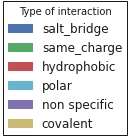

## Loading second set of data

In [13]:
titles2 = ['HYDROPHOBIC', 'HYDROPHOBIC_WITH_C', 'POLAR']
hydro, hydroC, polar = [get_net_list(string) for string in titles2]
L_dict_net2 = [hydro, hydroC, polar]

## Comparing hydro with/without C

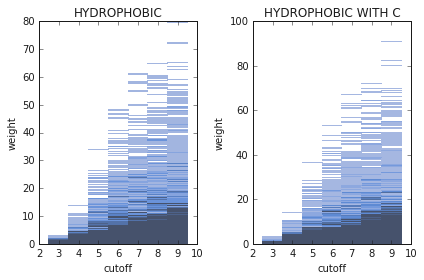

In [14]:
fig, axs = plt.subplots(1, 2)

for dict_net, title, ax in zip(L_dict_net2[:-1], titles2[:-1], axs.reshape(-1)):
    ax.set_title(title.replace('_', ' '))
    sns.histplot(create_dataframe(dict_net), x="cutoff", y="weight", discrete=(True, False), pmax=.05, ax=ax)
plt.tight_layout()
plt.show()
plt.close(fig) 

## Second definition for the type of interactions

In [15]:
def get_hydroperc(u, v, hydronet, polarnet):
    if (u,v) not in hydronet.edges() and (u, v) not in polarnet.edges():
        return np.nan
    elif (u,v) not in polarnet.edges():
        return 1
    elif (u,v) not in hydronet.edges():
        return 0
    else:
        return hydronet[u][v]['weight']/(hydronet[u][v]['weight']+polarnet[u][v]['weight'])

def get_toi2(u, v, hydronet, polarnet):
    hydro_perc = get_hydroperc(u, v, hydronet, polarnet)
    if hydro_perc == np.nan:
        return 'nothing'
    if hydro_perc >= 0.65:
        return 'hydrophobic'
    elif hydro_perc >= 0.35:
        return 'mixed'
    else:
        return 'polar'

L_interactions2 = ['hydrophobic', 'mixed', 'polar', 'nothing']

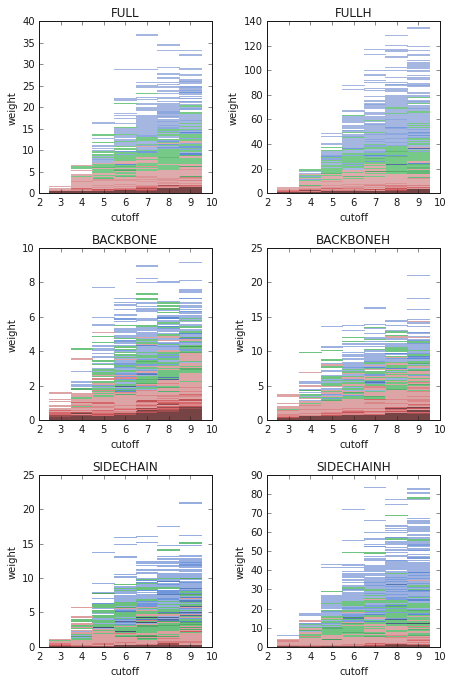

In [16]:
def create_dataframe2(dict_net, dict_hydro, dict_polar):
    df = pd.DataFrame(columns=['Type of interaction', 'cutoff', 'weight'])
#    for cutoff in dict_net:
    for cutoff in L_cutoffs:
        net = dict_net[cutoff]
        for toi in L_interactions2:
            edges_weight = [net[u][v]['weight'] for u, v in net.edges() if (get_toi2(u, v, dict_hydro[cutoff], dict_polar[cutoff]) == toi)]
            _df = pd.DataFrame({'Type of interaction': toi.replace('-', ' '), 'cutoff': cutoff, 'weight': edges_weight})
            df = pd.concat([df, _df])
    return df


fig, axs = plt.subplots(3, 2, figsize=[6.4, 9.6])

for dict_net, title, ax in zip(L_dict_net, titles, axs.reshape(-1)):
    ax.set_title(title)
    sns.histplot(create_dataframe2(dict_net, hydro, polar), x="cutoff", y="weight", hue='Type of interaction', discrete=(True, False), pmax=.05, ax=ax, legend=False)
plt.tight_layout()
plt.show()
plt.close(fig)


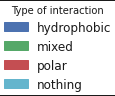

## What next?

### Show full plots with percentage
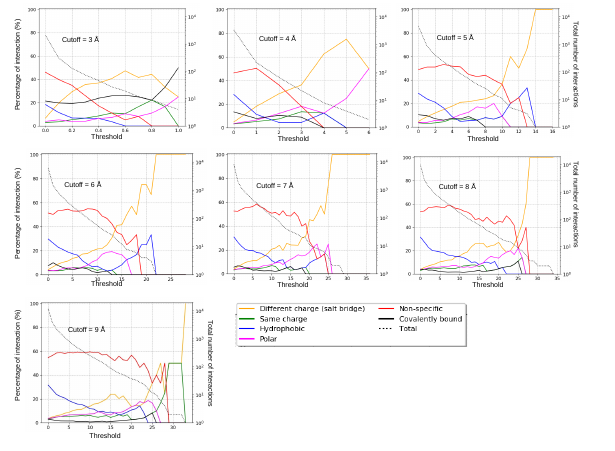
Pros:
* All the previous information is already there
* Mitigate our conclusion on the hydrophobic contacts : we can still somehow see them
* Uses the threshold and can give some insight about which threshold to use
  
Cons:
* Too much information if we want all cutoffs, all restrictions
* Tricky to analyze

### Use the second definition of contacts
I'm not sure I really see how to use it yet / if it's really needed

### Add information about the threshold:
For each type of contact I can also compute the range of "meaningful" contacts. This would be something like \[mean-std ; +\infty\] we could plot this instead of the mean and the std to give an insight about which threshold values to use for different type of contacts.

# New figures
## Check top 5 at Å

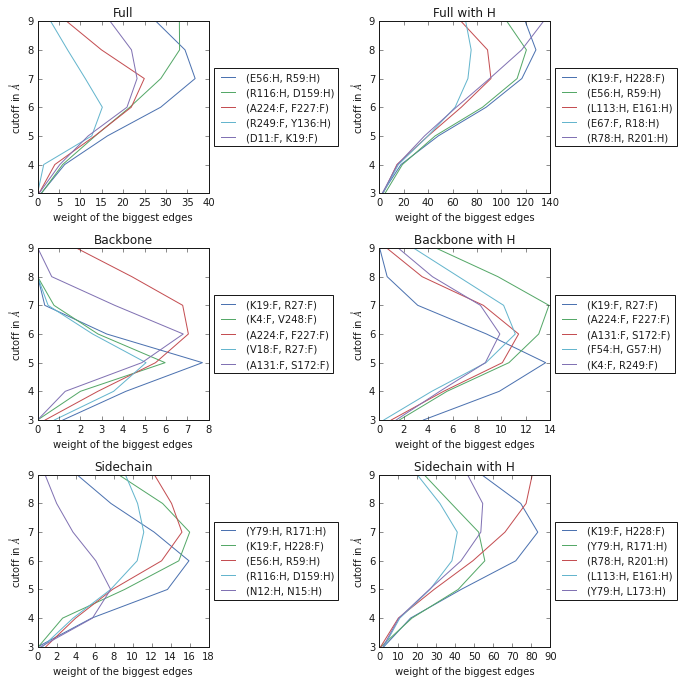

In [17]:
def plot_top_contacts_at5(k, dict_net, ax):
    table = np.zeros((7, k))
    ## Get topk at 5 A
    topk = sorted(dict_net[5].edges(data=True), key = lambda x: x[2]['weight'], reverse=True)[:k]
    edges = [elt[0:2] for elt in topk]    
    for i, j in enumerate(L_cutoffs):
        table[i] = [dict_net[j].edges()[edge]['weight'] if edge in dict_net[j].edges() else 0 for edge in edges]       
#    print(tabulate(np.transpose(table), headers=L_cutoffs, showindex = index,
#                  tablefmt="latex", floatfmt=".2f"))

#    fig = plt.figure()
    for i, edge in enumerate(edges):
        ax.plot(table[:,i], L_cutoffs, label=re.sub(r"'", "", str(edge)))
    ax.set_ylabel('cutoff in $\AA$')
    ax.set_xlabel('weight of the biggest edges')
    
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 10})

# fig, axs = plt.subplots(3, 2, sharex=True, sharey=True)
fig, axs = plt.subplots(3, 2, figsize=[9.6, 9.6])

for dict_net, title, ax in zip(L_dict_net, titles, axs.reshape(-1)):
    ax.set_title(re.sub(r"h$", " with H", title.capitalize()))
    plot_top_contacts_at5(5, dict_net, ax)

plt.tight_layout()
plt.show()
plt.close(fig)

## Top5 of salt bridge vs rest

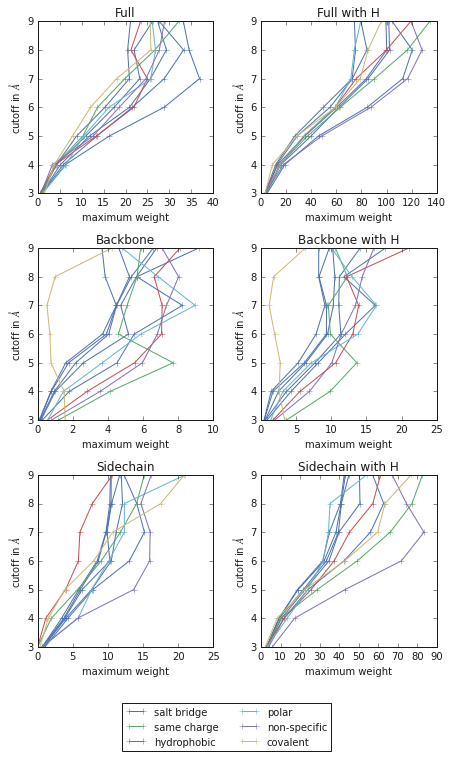

In [18]:
def plot_top5sbVrest(dict_net, ax):
    for toi in L_interactions:
        X = np.zeros(7)
        if toi == 'salt_bridge':
            X = np.zeros((7,5))
        for i, j in enumerate(L_cutoffs):
            net = dict_net[j]
            edges_weight = [net[u][v]['weight'] for u, v in net.edges() if get_toi(u, v) == toi]
            if toi == 'salt_bridge':
                X[i] = np.array(edges_weight)[np.array(edges_weight).argsort()[-5:][::-1]]
            else:
                X[i] = np.max(edges_weight)
        if toi == 'salt_bridge':
            for i in range(5):
                if i==0:
                    ax.plot(X[:,i], L_cutoffs, marker='+', color=toi2colors[toi], label='salt bridge')
                else:
                    ax.plot(X[:,i], L_cutoffs, marker='+', color=toi2colors[toi])
        else:
            ax.plot(X, L_cutoffs, marker='+', label=toi.replace('_', ' '), color=toi2colors[toi])
        ax.set_xlabel('maximum weight')
        ax.set_ylabel('cutoff in $\AA$')

fig, axs = plt.subplots(3, 2, figsize=[6.4, 9.6])

for dict_net, title, ax in zip(L_dict_net, titles, axs.reshape(-1)):
    ax.set_title(re.sub(r"h$", " with H", title.capitalize()))
    plot_top5sbVrest(dict_net, ax)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.1), prop={'size': 10}, ncol=2)
plt.tight_layout()
plt.show()
plt.close(fig)

## Percentage of hydrophobicity for all interaction type

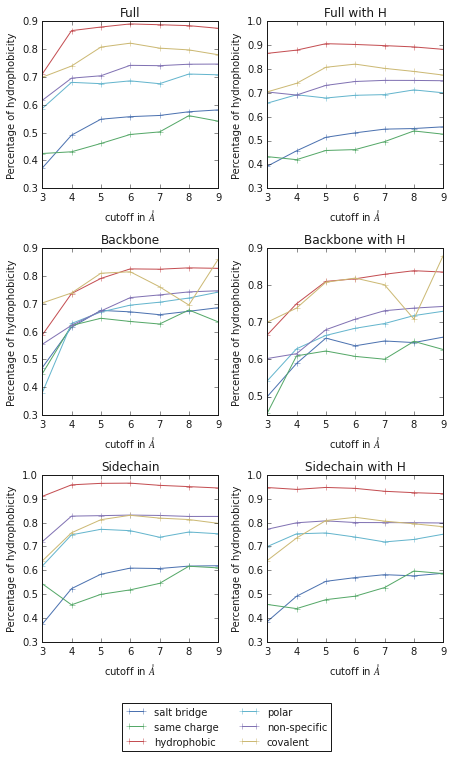

In [19]:
def plot_percentage_hydro(dict_net, dict_hydro, dict_polar, ax=None):
    if ax==None:
        ax=plt.gca()
    for toi in L_interactions:
        X = np.zeros(7)
        for i, cutoff in enumerate(L_cutoffs):
            net = dict_net[cutoff]
            # compute the mean percentage of hydrophobicity in the type of interaction at a given cutoff
            hydroperc = [get_hydroperc(u, v, dict_hydro[cutoff], dict_polar[cutoff]) for u, v in net.edges() if (get_toi(u, v) == toi)]
            try:
                X[i]=(np.nanmean(hydroperc))
            except TypeError:
                X[i] = 0
                print(toi, cutoff, dict_net[cutoff])
        ax.plot(L_cutoffs, X, marker='+', label=toi.replace('_', ' '), color=toi2colors[toi])
    ax.set_xlabel('cutoff in $\AA$')
    ax.set_ylabel('Percentage of hydrophobicity')
       
fig, axs = plt.subplots(3, 2, figsize=[6.4, 9.6])

for dict_net, title, ax in zip(L_dict_net, titles, axs.reshape(-1)):
    ax.set_title(re.sub(r"h$", " with H", title.capitalize()))
    plot_percentage_hydro(dict_net, hydroC, polar, ax)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.1), prop={'size': 10}, ncol=2)
plt.tight_layout()
plt.show()
plt.close(fig) 

## Plot distributions

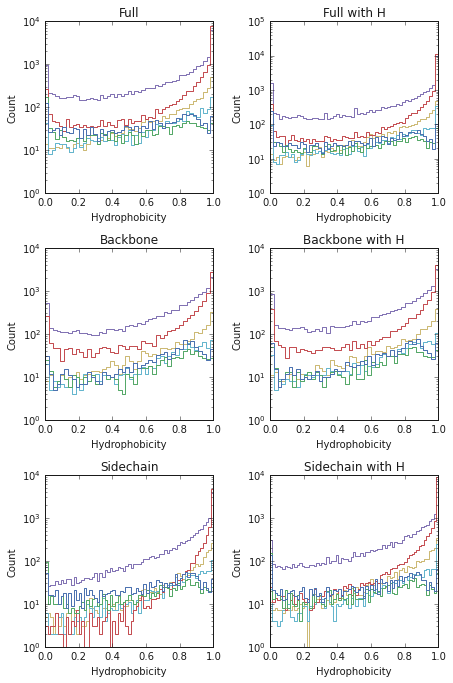

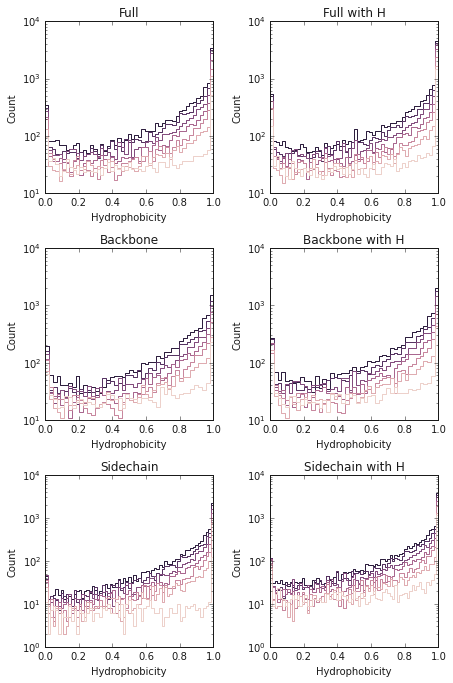

In [20]:
def dataframe_hydroperc(dict_net, dict_hydro, dict_polar):
    df = pd.DataFrame(columns=['Type of interaction', 'cutoff', 'Hydrophobicity'])
    for toi in L_interactions:
        for i, cutoff in enumerate(L_cutoffs):
            net = dict_net[cutoff]
            # compute the mean percentage of hydrophobicity in the type of interaction at a given cutoff
            hydroperc = np.array([get_hydroperc(u, v, dict_hydro[cutoff], dict_polar[cutoff]) for u, v in net.edges() if (get_toi(u, v) == toi)])
            # Remove nan values (nothing interaction)
            hydroperc = hydroperc[np.where(~np.isnan(hydroperc))]
            _df = pd.DataFrame({'Type of interaction': toi, 'cutoff': cutoff, 'Hydrophobicity': hydroperc})
            df = pd.concat([df, _df])     
    return df

fig, axs = plt.subplots(3, 2, figsize=[6.4, 9.6])

for dict_net, title, ax in zip(L_dict_net, titles, axs.reshape(-1)):
    ax.set_title(re.sub(r"h$", " with H", title.capitalize()))
    df = dataframe_hydroperc(dict_net, hydroC, polar)
#    sns.histplot(df, x="cutoff", y="Hydrophobicity", discrete=(True, False), ax=ax)
    cutoff5 = df.loc[df['cutoff']==5]
    sns.histplot(df, x="Hydrophobicity", ax=ax, hue='Type of interaction', element='step', log_scale=[False, True], fill=False, legend=False)
plt.tight_layout()
plt.show()
plt.close(fig)


fig, axs = plt.subplots(3, 2, figsize=[6.4, 9.6])

for dict_net, title, ax in zip(L_dict_net, titles, axs.reshape(-1)):
    ax.set_title(re.sub(r"h$", " with H", title.capitalize()))
    df = dataframe_hydroperc(dict_net, hydroC, polar)
#    sns.histplot(df, x="cutoff", y="Hydrophobicity", discrete=(True, False), ax=ax)
    sns.histplot(df, x="Hydrophobicity", hue='cutoff', ax=ax, element='step', log_scale=[False, True], fill=False, legend=False)
plt.tight_layout()
plt.show()
plt.close(fig)


## "Third" definition of type of contact

In [21]:
def create_toi3(dict_fullH, dict_hydro, dict_polar, keep_mixed=False, polar_output=True):
    if polar_output:
        toi3 = {}
    else:
        dpolar, dmixed, dhydro = {}, {}, {}
    for cutoff in dict_fullH:
        if polar_output:
            toi3[cutoff] = {}
        else:
            dpolar[cutoff], dmixed[cutoff], dhydro[cutoff] = {}, {}, {}
        net = dict_fullH[cutoff]
        hydronet, polarnet = dict_hydro[cutoff], dict_polar[cutoff]
        for u, v in net.edges():
            mixed = net.edges()[(u,v)]['weight']
            if (u, v) not in hydronet.edges() and (u, v) not in polarnet.edges():
                total = mixed
                hydro, polar = 0, 0
            elif (u, v) not in hydronet.edges():
                polar = polarnet.edges()[(u,v)]['weight']
                total = polar+mixed
                hydro = 0
            elif (u, v) not in polarnet.edges():
                hydro = hydronet.edges()[(u,v)]['weight']
                total = hydro+mixed
                polar = 0
            else:
                hydro = hydronet.edges()[(u,v)]['weight']
                polar = polarnet.edges()[(u,v)]['weight']
                total = hydro+polar+mixed
            if polar_output:
                if keep_mixed:
                    toi3[cutoff][(u,v)] = (polar+mixed)/total
                else:
                    toi3[cutoff][(u,v)] = polar/total
            else:
                dpolar[cutoff][(u,v)] = polar/total
                dmixed[cutoff][(u,v)] = mixed/total
                dhydro[cutoff][(u,v)] = hydro/total
    if polar_output:
        return toi3
    else:
        return dpolar, dmixed, dhydro
        

toi3 = create_toi3(fullH, hydro, polar)
toi3_mixed = create_toi3(fullH, hydro, polar, keep_mixed=True)
polar3, mixed3, hydro3 = create_toi3(fullH, hydro, polar, polar_output=False)
                

## Percentage plot 3

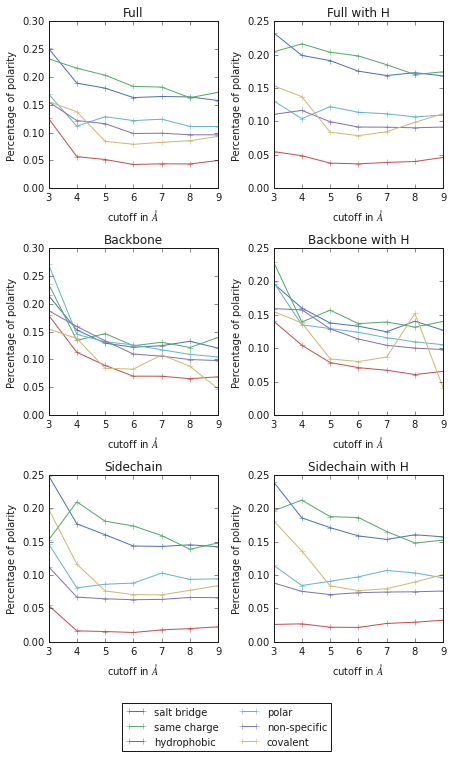

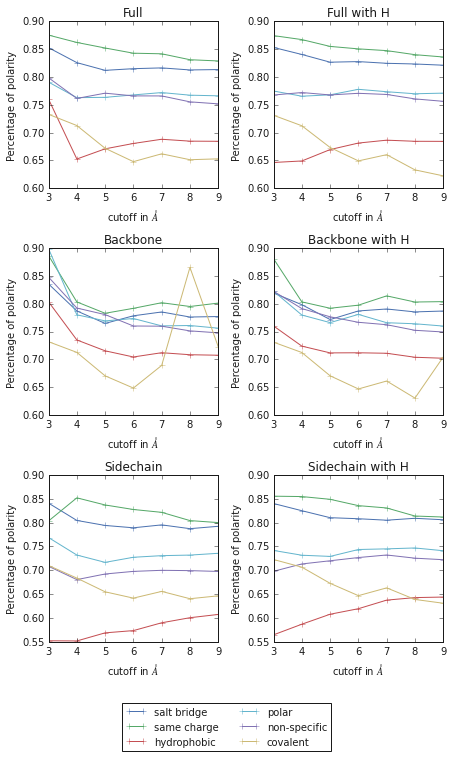

In [22]:
def plot_percentage_polar(dict_net, dict_toi, ax=None):
    if ax==None:
        ax=plt.gca()
    for toi in L_interactions:
        X = np.zeros(7)
        for i, cutoff in enumerate(L_cutoffs):
            net = dict_net[cutoff]
            # compute the mean percentage of hydrophobicity in the type of interaction at a given cutoff
            hydroperc = np.array([dict_toi[cutoff][(u, v)] if (u, v) in dict_toi[cutoff] else np.nan for u, v in net.edges() if (get_toi(u, v) == toi)])
            try:
                X[i]=(np.nanmean(hydroperc))
            except TypeError:
                X[i] = 0
                print(toi, cutoff, dict_net[cutoff])
        ax.plot(L_cutoffs, X, marker='+', label=toi.replace('_', ' '), color=toi2colors[toi])
    ax.set_xlabel('cutoff in $\AA$')
    ax.set_ylabel('Percentage of polarity')
       
fig, axs = plt.subplots(3, 2, figsize=[6.4, 9.6])
for dict_net, title, ax in zip(L_dict_net, titles, axs.reshape(-1)):
    ax.set_title(re.sub(r"h$", " with H", title.capitalize()))
    plot_percentage_polar(dict_net, toi3, ax)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.1), prop={'size': 10}, ncol=2)
plt.tight_layout()
plt.show()
plt.close(fig) 

fig, axs = plt.subplots(3, 2, figsize=[6.4, 9.6])
for dict_net, title, ax in zip(L_dict_net, titles, axs.reshape(-1)):
    ax.set_title(re.sub(r"h$", " with H", title.capitalize()))
    plot_percentage_polar(dict_net, toi3_mixed, ax)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.1), prop={'size': 10}, ncol=2)
plt.tight_layout()
plt.show()
plt.close(fig) 

## Distribution plot 3

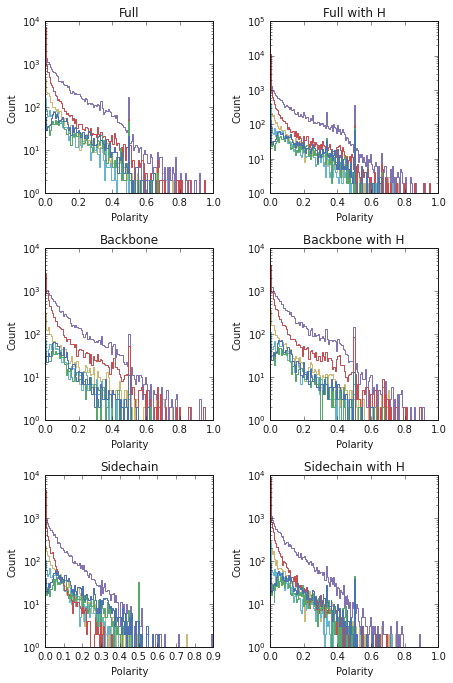

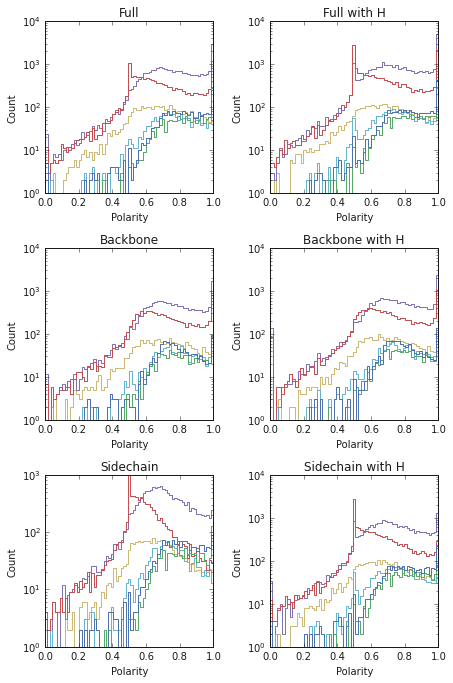

In [23]:
def create_df_toi3(dict_net, dict_toi):
    df = pd.DataFrame(columns=['Type of interaction', 'cutoff', 'Polarity'])
    for toi in L_interactions:
        for i, cutoff in enumerate(L_cutoffs):
            net = dict_net[cutoff]
            # retrieve the hydrophobicity in the type of interaction at a given cutoff
            hydroperc = np.array([dict_toi[cutoff][(u, v)] if (u, v) in dict_toi[cutoff] else 0 for u, v in net.edges() if (get_toi(u, v) == toi)])
            _df = pd.DataFrame({'Type of interaction': toi, 'cutoff': cutoff, 'Polarity': hydroperc})
            df = pd.concat([df, _df])     
    return df

fig, axs = plt.subplots(3, 2, figsize=[6.4, 9.6])

for dict_net, title, ax in zip(L_dict_net, titles, axs.reshape(-1)):
    ax.set_title(re.sub(r"h$", " with H", title.capitalize()))
    df = create_df_toi3(dict_net, toi3)
#    sns.histplot(df, x="cutoff", y="Hydrophobicity", discrete=(True, False), ax=ax)
    cutoff5 = df.loc[df['cutoff']==5]
    sns.histplot(df, x="Polarity", ax=ax, hue='Type of interaction', element='step', log_scale=[False, True], fill=False, legend=False)
plt.tight_layout()
plt.show()
plt.close(fig)

fig, axs = plt.subplots(3, 2, figsize=[6.4, 9.6])

for dict_net, title, ax in zip(L_dict_net, titles, axs.reshape(-1)):
    ax.set_title(re.sub(r"h$", " with H", title.capitalize()))
    df = create_df_toi3(dict_net, toi3_mixed)
#    sns.histplot(df, x="cutoff", y="Hydrophobicity", discrete=(True, False), ax=ax)
    cutoff5 = df.loc[df['cutoff']==5]
    sns.histplot(df, x="Polarity", ax=ax, hue='Type of interaction', element='step', log_scale=[False, True], fill=False, legend=False)
plt.tight_layout()
plt.show()
plt.close(fig)


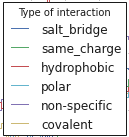

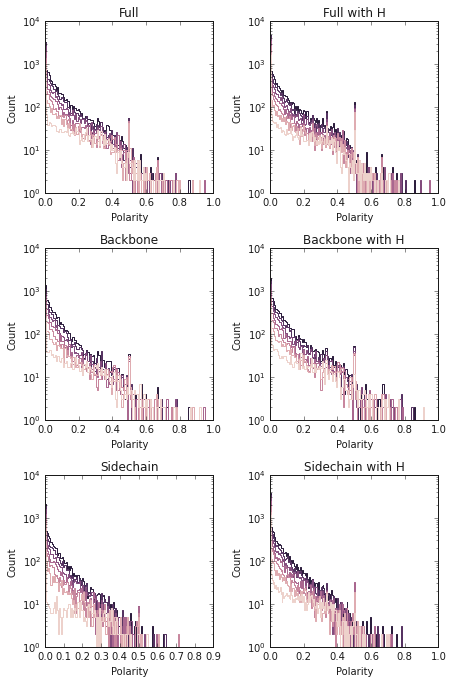

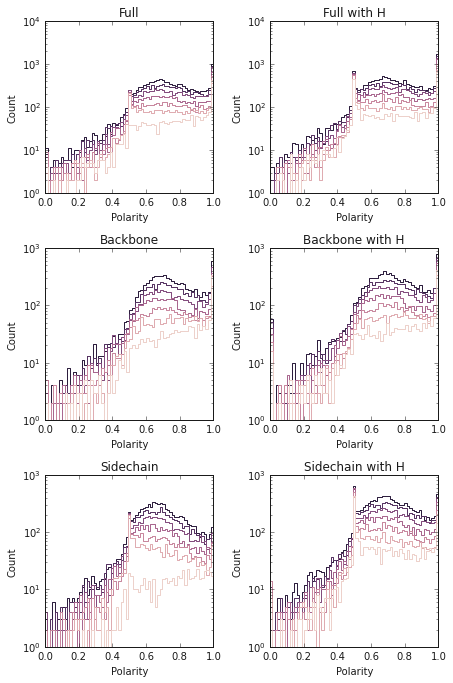

In [24]:
fig, axs = plt.subplots(3, 2, figsize=[6.4, 9.6])

for dict_net, title, ax in zip(L_dict_net, titles, axs.reshape(-1)):
    ax.set_title(re.sub(r"h$", " with H", title.capitalize()))
    df = create_df_toi3(dict_net, toi3)
#    sns.histplot(df, x="cutoff", y="Hydrophobicity", discrete=(True, False), ax=ax)
    sns.histplot(df, x="Polarity", hue='cutoff', ax=ax, element='step', log_scale=[False, True], fill=False, legend=False)
plt.tight_layout()
plt.show()
plt.close(fig)

fig, axs = plt.subplots(3, 2, figsize=[6.4, 9.6])

for dict_net, title, ax in zip(L_dict_net, titles, axs.reshape(-1)):
    ax.set_title(re.sub(r"h$", " with H", title.capitalize()))
    df = create_df_toi3(dict_net, toi3_mixed)
#    sns.histplot(df, x="cutoff", y="Hydrophobicity", discrete=(True, False), ax=ax)
    sns.histplot(df, x="Polarity", hue='cutoff', ax=ax, element='step', log_scale=[False, True], fill=False, legend=False)
plt.tight_layout()
plt.show()
plt.close(fig)

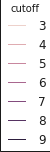


## Distribution of cutoff that gives top weight

Small remark: I selected only edges seen at cutoff 5. Maybe we can/should do this another way. Kinda bad

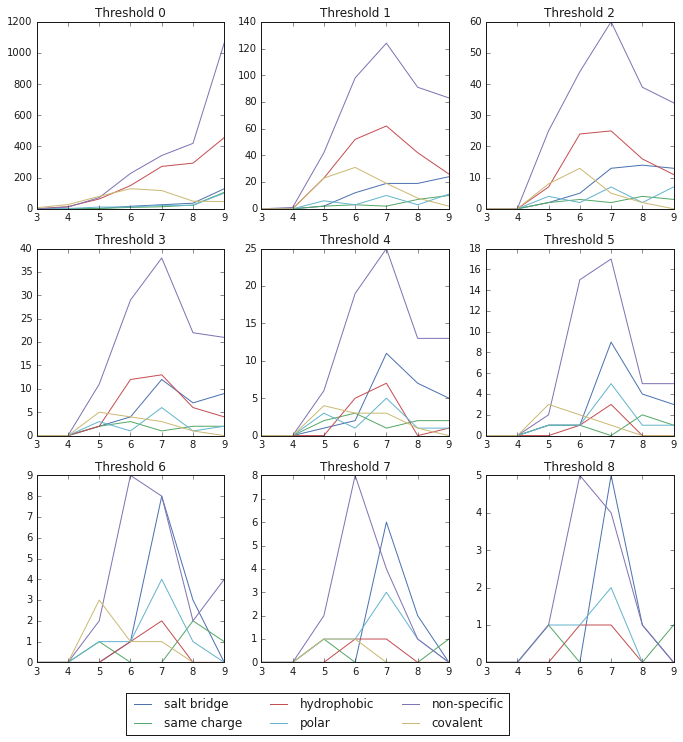

In [25]:
def distribution_top_cutoff(dict_net, thresh=1, cutoff=5, ax=None, al=False):
    #Definition of the DataFrame
    toi2counts = {toi: np.zeros(7) for toi in L_interactions}
    
    #Selection of edges to consider
    for (u, v) in dict_net[cutoff].edges():
        if dict_net[cutoff].edges()[(u, v)]['weight'] >= thresh:
            toi = get_toi(u,v)
            #Get the weights for each cutoff
            weights = [dict_net[cutoff].edges()[(u,v)]['weight'] if (u,v) in dict_net[cutoff].edges() else 0 for cutoff in L_cutoffs]
            #Get the top cutoff
            top_cutoff = weights.index(max(weights)) #careful it's the cutoff-3 here
            toi2counts[toi][top_cutoff]+=1
    for toi in L_interactions:
        if al == False:
            ax.plot(L_cutoffs, toi2counts[toi], color=toi2colors[toi], label=toi.replace('_', ' '))
        else:
            ax.plot(L_cutoffs, toi2counts[toi], color=toi2colors[toi])
    if al == False:
        al = True
        
fig, axs = plt.subplots(3, 3, figsize=[9.6, 9.6])
al = False
for thresh, ax in enumerate(axs.reshape(-1)):
    ax.set_title('Threshold %s' % thresh)
    al = distribution_top_cutoff(full, thresh=thresh, ax=ax, al=al)
    fig.legend(bbox_to_anchor=(0.75,0), ncol=3)
plt.tight_layout()
plt.show()
plt.close(fig) 

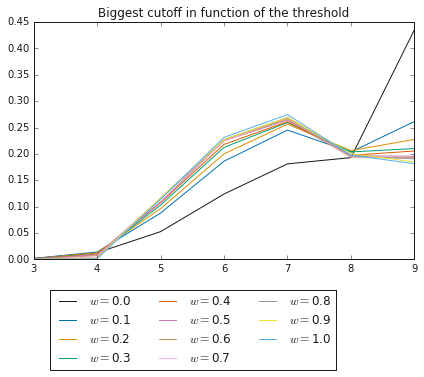

In [26]:
#Number of thresholds seen
step = 0.1
k=11
palette = sns.color_palette("colorblind", k)
import itertools
colors = itertools.cycle(palette)

def distribution_top_cutoff(dict_net, thresh=1, cutoff=5, ax=None):
    counts = np.zeros(7)
    #Selection of edges to consider
    for (u, v) in dict_net[cutoff].edges():
        if dict_net[cutoff].edges()[(u, v)]['weight'] >= thresh:
            #Get the weights for each cutoff
            weights = [dict_net[cutoff].edges()[(u,v)]['weight'] if (u,v) in dict_net[cutoff].edges() else 0 for cutoff in L_cutoffs]
            #Get the top cutoff
            top_cutoff = weights.index(max(weights)) #careful it's the cutoff-3 here
            counts[top_cutoff]+=1
    freq = counts/np.sum(counts)
    if thresh != 0:
        ax.plot(L_cutoffs, freq, color=next(colors), label='$w=$%s'% round(thresh, 2))
    else:
        ax.plot(L_cutoffs, freq, color='k', label='$w=$%s'% round(thresh, 2))
        
        
fig, ax = plt.subplots(1,1)
for thresh in np.arange(0, k*step, step):
    ax.set_title('Biggest cutoff in function of the threshold')
    distribution_top_cutoff(full, thresh=thresh, ax=ax)
    fig.legend(bbox_to_anchor=(0.8,0), ncol=3)
plt.tight_layout()
plt.show()
plt.close(fig) 

## Difference between gains and losses in percentage of hydrophobicity

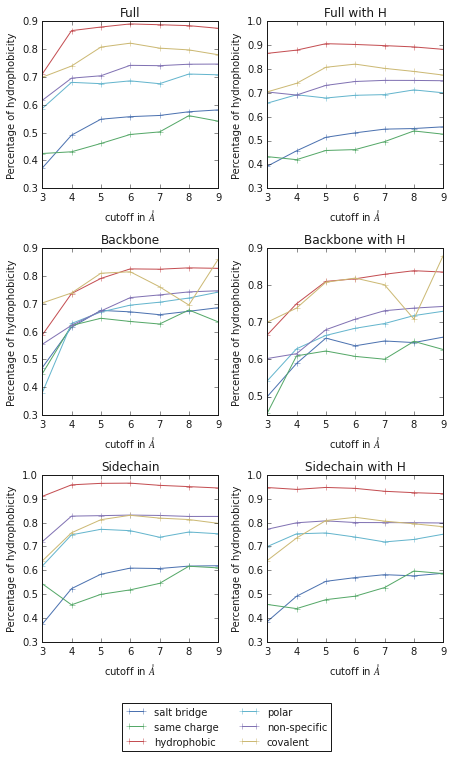

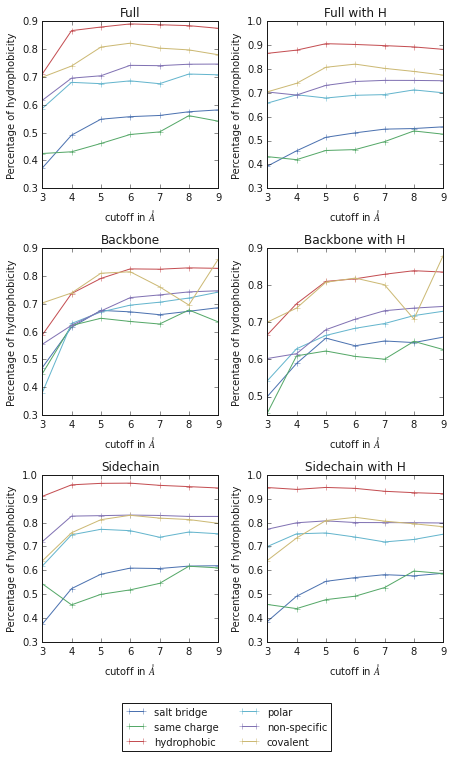

In [27]:
def plot_percentage_hydro_colored(dict_net, dict_hydro, dict_polar, color, ax=None):
    if ax==None:
        ax=plt.gca()
    for toi in L_interactions:
        X = np.zeros(7)
        for i, cutoff in enumerate(L_cutoffs):
            net = dict_net[cutoff]
            # compute the mean percentage of hydrophobicity in the type of interaction at a given cutoff
            hydroperc = [get_hydroperc(u, v, dict_hydro[cutoff], dict_polar[cutoff]) for u, v in net.edges() if (get_toi(u, v) == toi) and net.edges()[(u, v)]['color']]
            try:
                X[i]=(np.nanmean(hydroperc))
            except TypeError:
                X[i] = 0
                print(toi, cutoff, dict_net[cutoff])
        ax.plot(L_cutoffs, X, marker='+', label=toi.replace('_', ' '), color=toi2colors[toi])
    ax.set_xlabel('cutoff in $\AA$')
    ax.set_ylabel('Percentage of hydrophobicity')
       
fig, axs = plt.subplots(3, 2, figsize=[6.4, 9.6])

for dict_net, title, ax in zip(L_dict_net, titles, axs.reshape(-1)):
    ax.set_title(re.sub(r"h$", " with H", title.capitalize()))
    plot_percentage_hydro_colored(dict_net, hydroC, polar, 'r', ax)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.1), prop={'size': 10}, ncol=2)
plt.tight_layout()
plt.show()
plt.close(fig) 

fig, axs = plt.subplots(3, 2, figsize=[6.4, 9.6])

for dict_net, title, ax in zip(L_dict_net, titles, axs.reshape(-1)):
    ax.set_title(re.sub(r"h$", " with H", title.capitalize()))
    plot_percentage_hydro_colored(dict_net, hydroC, polar, 'g', ax)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.1), prop={'size': 10}, ncol=2)
plt.tight_layout()
plt.show()
plt.close(fig) 

## FullH for each type with definition III

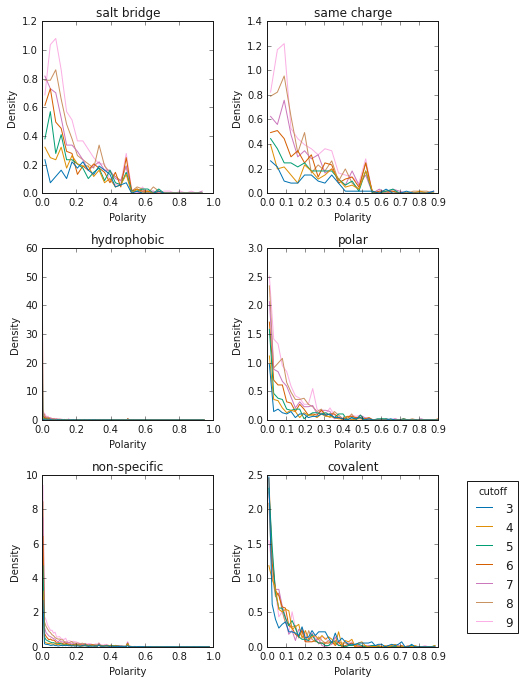

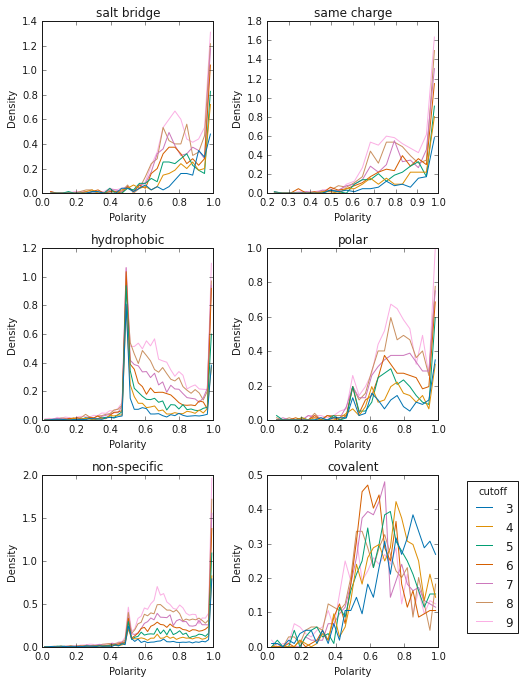

In [28]:
def distrib_bytype_def3(dict_net, dict_toi):
    fig, axs = plt.subplots(3, 2, figsize=[6.4, 9.6])

    for toi, ax in zip(L_interactions, axs.reshape(-1)):
        ax.set_title(toi.replace('_', ' '))
        df = create_df_toi3(dict_net, dict_toi)
    #    sns.histplot(df, x="cutoff", y="Hydrophobicity", discrete=(True, False), ax=ax)
        newdf = df.loc[df['Type of interaction']==toi]
        g = sns.histplot(newdf, x="Polarity", ax=ax, hue='cutoff', element='poly', fill=False, legend=(toi==L_interactions[-1]), palette='colorblind', stat='density')
    legend = g.get_legend()
    plt.tight_layout()
    legend.set_bbox_to_anchor((1.5,1))
    #plt.tight_layout()
    plt.show()
    plt.close(fig)

distrib_bytype_def3(fullH, toi3)
distrib_bytype_def3(fullH, toi3_mixed)


## Without hydrogens

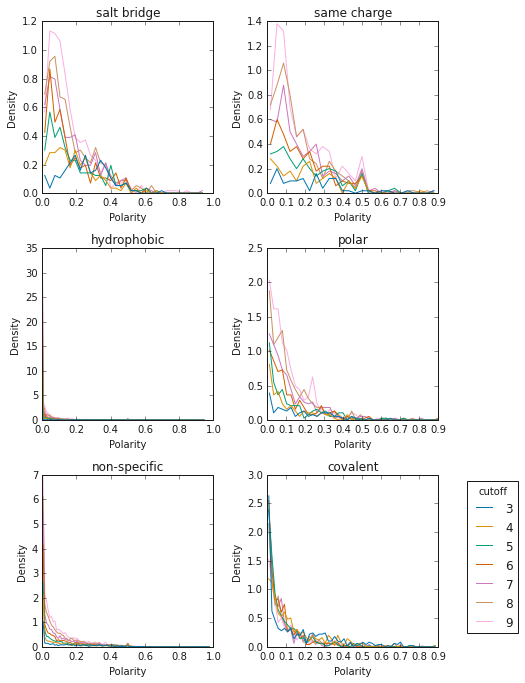

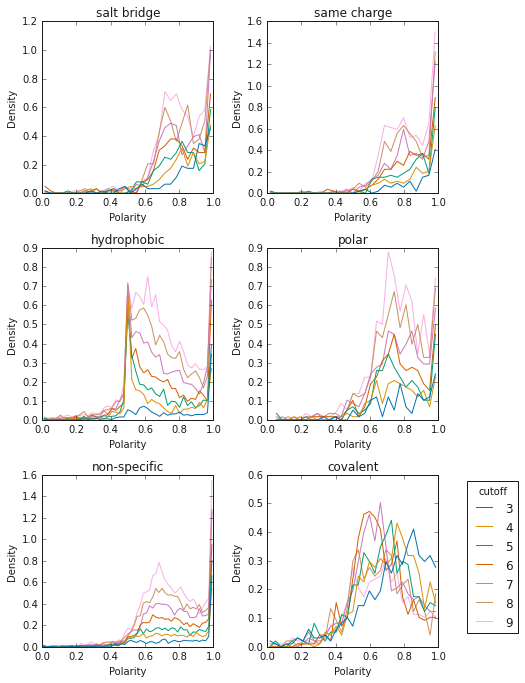

In [29]:
distrib_bytype_def3(full, toi3)
distrib_bytype_def3(full, toi3_mixed)

## Type of interaction per defintion of contact

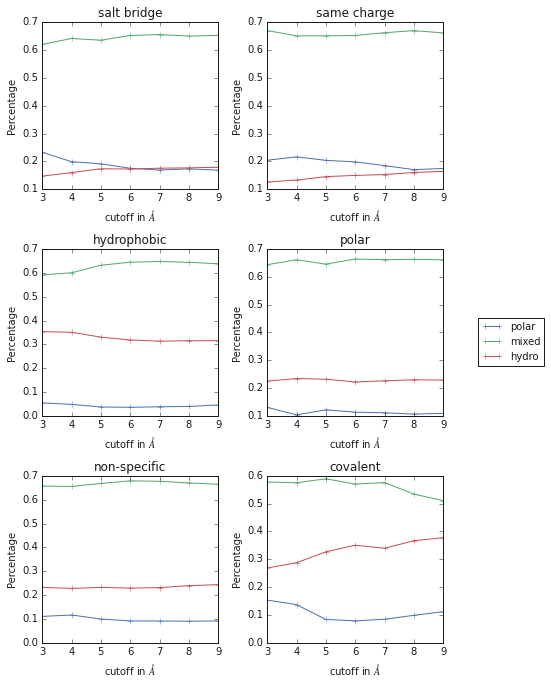

In [30]:
L_dict_toi3 = [polar3, mixed3, hydro3]

def dict_to_X(dict_toi, dict_net):
    X = np.zeros(7)
    for i, cutoff in enumerate(L_cutoffs):
        net = dict_net[cutoff]
        perc = np.array([dict_toi[cutoff][(u, v)] if (u, v) in dict_toi[cutoff] else np.nan for u, v in net.edges() if (get_toi(u, v) == toi)])
        try:
            X[i]=(np.nanmean(perc))
        except TypeError:
            X[i] = 0
            print('TypeError')
    return X

def percentage_perdef3(dict_net, L_dict_toi, ax=None):
    Xpolar, Xmixed, Xhydro = map(dict_to_X, L_dict_toi, [dict_net]*len(L_dict_toi))
    ax.plot(L_cutoffs, Xpolar, marker='+', label='polar')
    ax.plot(L_cutoffs, Xmixed, marker='+', label='mixed')
    ax.plot(L_cutoffs, Xhydro, marker='+', label='hydro')
    ax.set_xlabel('cutoff in $\AA$')
    ax.set_ylabel('Percentage')


fig, axs = plt.subplots(3, 2, figsize=[6.4, 9.6])

for toi, ax in zip(L_interactions, axs.reshape(-1)):
    ax.set_title(toi.replace('_', ' '))
    percentage_perdef3(fullH, L_dict_toi3, ax=ax)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.2,  0.5), prop={'size': 10})
plt.tight_layout()
plt.show()
plt.close(fig) 

## Without hydrogens

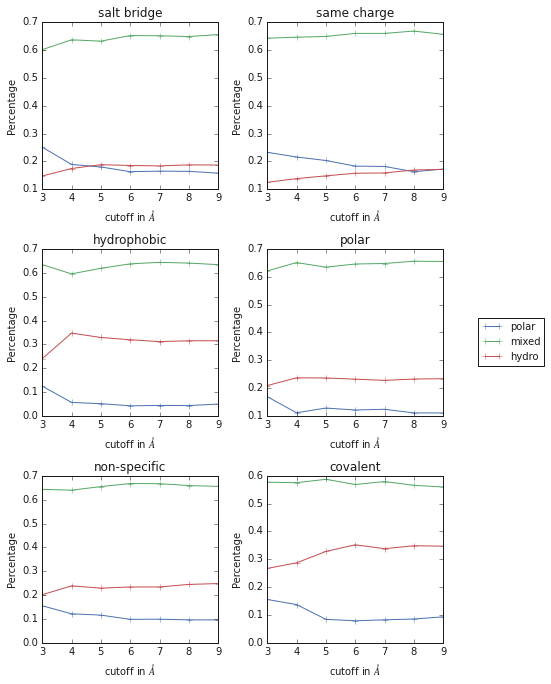

In [31]:
fig, axs = plt.subplots(3, 2, figsize=[6.4, 9.6])

for toi, ax in zip(L_interactions, axs.reshape(-1)):
    ax.set_title(toi.replace('_', ' '))
    percentage_perdef3(full, L_dict_toi3, ax=ax)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.2,  0.5), prop={'size': 10})
plt.tight_layout()
plt.show()
plt.close(fig) 

## Check same-charge & salt-bridge top polarity & hydrophobicity

In [32]:
df = pd.DataFrame(columns=['type_of_interaction', 'top', 'top_polar', 'value_polar', 'weight_polar', 'top_hydro', 'value_hydro', 'weight_hydro'])
for toi in ['same_charge', 'salt_bridge']:
    hydroperc = np.array([L_dict_toi3[-1][5][(u, v)] if (u, v) in L_dict_toi3[-1][5] else np.nan for u, v in fullH[5].edges() if (get_toi(u, v) == toi)])
    polarperc = np.array([L_dict_toi3[0][5][(u, v)] if (u, v) in L_dict_toi3[0][5] else np.nan for u, v in fullH[5].edges() if (get_toi(u, v) == toi)])
    edges = np.array([(u,v) for u, v in fullH[5].edges() if (get_toi(u, v) == toi)])
    weights = np.array([fullH[5].edges()[(u,v)]['weight'] for u, v in fullH[5].edges() if (get_toi(u, v) == toi)])
    id_polar = np.argsort(polarperc)[:-6:-1]
    top_polar = edges[id_polar]
    values_polar = polarperc[id_polar]
    weights_polar = weights[id_polar]
    id_hydro = np.argsort(hydroperc)[:-6:-1]
    top_hydro = edges[np.argsort(hydroperc)[:-6:-1]]
    values_hydro = hydroperc[id_hydro]
    weights_hydro = weights[id_hydro]
    merge_top = lambda arr: arr[0] + '--' + arr[1]
    top_polar = np.apply_along_axis(merge_top,-1,top_polar)    
    top_hydro = np.apply_along_axis(merge_top,-1,top_hydro) 
    df = df.append(pd.DataFrame({'type_of_interaction':toi, 'top': range(1,6), 'top_polar':top_polar, 'value_polar': values_polar, 'weight_polar': weights_polar,
                            'top_hydro': top_hydro, 'value_hydro': values_hydro, 'weight_hydro': weights_hydro}), ignore_index=True)

print(df.to_string(index=False))    


type_of_interaction top     top_polar  value_polar  weight_polar       top_hydro  value_hydro  weight_hydro
        same_charge   1  D44:H--E77:H     0.666667       0.00025  E159:F--E161:F     0.759197       0.00700
        same_charge   2  E71:F--D74:F     0.666667       0.00200   E71:F--E180:H     0.500000       0.00100
        same_charge   3  K58:F--K60:F     0.625351       0.15100   R27:F--R230:F     0.500000       0.00050
        same_charge   4  K206:F--R230     0.500000       0.00025    D11:F--D51:F     0.477939       0.36800
        same_charge   5  D31:F--E64:F     0.500000       0.00125  K184:H--K188:H     0.397058       1.82375
        salt_bridge   1  D51:F--R59:F     0.666667       0.00025    R39:H--D41:H     0.839894       0.25500
        salt_bridge   2  K129:H--E148     0.666667       0.00050    K72:H--D76:H     0.619048       0.04575
        salt_bridge   3  D76:H--R171:     0.619048       0.00900    E71:F--R18:H     0.598906       3.36525
        salt_bridge   4  R62

The found interactions all have small weights, add a threshold?

In [37]:
thresh = 1
topk = 7
df = pd.DataFrame(columns=['type_of_interaction', 'top', 'top_polar', 'value_polar', 'weight_polar', 'top_hydro', 'value_hydro', 'weight_hydro'])
for toi in ['same_charge', 'salt_bridge']:
    hydroperc = np.array([L_dict_toi3[-1][5][(u, v)] if (u, v) in L_dict_toi3[-1][5] else np.nan for u, v in fullH[5].edges() if (get_toi(u, v) == toi and fullH[5].edges()[(u,v)]['weight'] >= thresh)])
    polarperc = np.array([L_dict_toi3[0][5][(u, v)] if (u, v) in L_dict_toi3[0][5] else np.nan for u, v in fullH[5].edges() if (get_toi(u, v) == toi and fullH[5].edges()[(u,v)]['weight'] >= thresh)])
    edges = np.array([(u,v) for u, v in fullH[5].edges() if (get_toi(u, v) == toi and fullH[5].edges()[(u,v)]['weight'] >= thresh)])
    weights = np.array([fullH[5].edges()[(u,v)]['weight'] for u, v in fullH[5].edges() if (get_toi(u, v) == toi and fullH[5].edges()[(u,v)]['weight'] >= thresh)])
    id_polar = np.argsort(polarperc)[:-(1+topk):-1]
    top_polar = edges[id_polar]
    values_polar = polarperc[id_polar]
    weights_polar = weights[id_polar]
    id_hydro = np.argsort(hydroperc)[:-(1+topk):-1]
    top_hydro = edges[np.argsort(hydroperc)[:-(1+topk):-1]]
    values_hydro = hydroperc[id_hydro]
    weights_hydro = weights[id_hydro]
    merge_top = lambda arr: arr[0] + '--' + arr[1]
    top_polar = np.apply_along_axis(merge_top,-1,top_polar)    
    top_hydro = np.apply_along_axis(merge_top,-1,top_hydro) 
    df = df.append(pd.DataFrame({'type_of_interaction':toi, 'top': range(1,1+topk), 'top_polar':top_polar, 'value_polar': values_polar, 'weight_polar': weights_polar,
                            'top_hydro': top_hydro, 'value_hydro': values_hydro, 'weight_hydro': weights_hydro}), ignore_index=True)

print(df.to_string(index=False))    


type_of_interaction top       top_polar  value_polar  weight_polar       top_hydro  value_hydro  weight_hydro
        same_charge   1  R114:H--R144:H     0.321045       4.90325  K184:H--K188:H     0.397058       1.82375
        same_charge   2  R133:F--R175:F     0.320163       1.73225    E67:F--E71:F     0.394084       1.16225
        same_charge   3  R171:H--R201:H     0.319599       9.53800  E148:H--E150:H     0.389488       1.23700
        same_charge   4   R78:H--R171:H     0.254959      13.51000  R235:F--K238:F     0.382386       5.55950
        same_charge   5   K37:F--R187:H     0.253782       2.26825    R18:H--K21:H     0.369786       5.44950
        same_charge   6     R2:H--R78:H     0.232207       1.10175   D74:F--E180:H     0.359293       4.62200
        same_charge   7   R22:H--R187:H     0.213793      10.79875    K37:F--R22:H     0.356201       2.16600
        salt_bridge   1  R175:F--D183:F     0.310981       1.60475    E71:F--R18:H     0.598906       3.36525
        sa

## Top polar
*h*R114 -- *h*R144
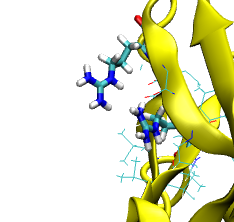
probably water-mediated <br />
*h*R171 -- *h*R201
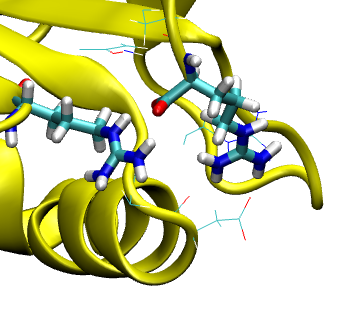
OXT interaction <br />
*h*R78 -- *h*R171
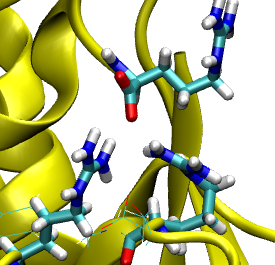
again OXT, but triangle... <br />
*f*K37 -- *h*R187
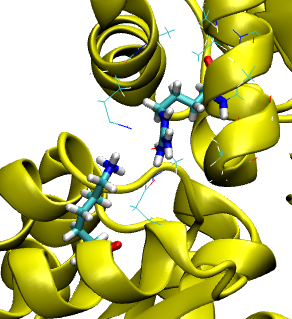
water-mediated <br />
*h*R2 -- *h*R78 
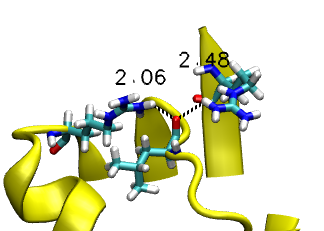
triangle H-bond with L43 <br />
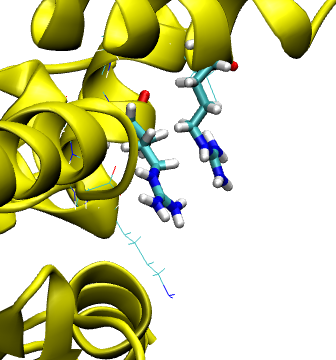
water-mediated 

## Top hydro
*h*K184 -- *h*K188
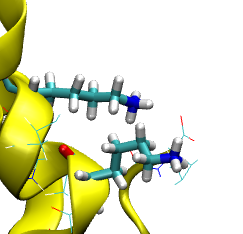
hydrophobic interaction <br />
*h*E67 -- *h*E71
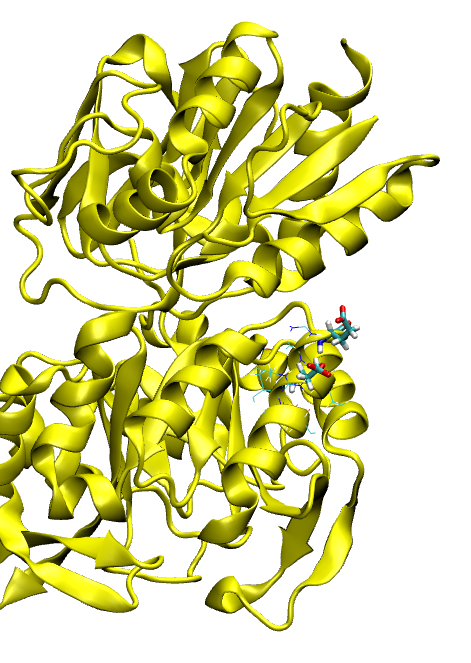
inside the well-known cluster of salt bridges (might not be significant due to low weight) <br />
*f*235-- *f*238
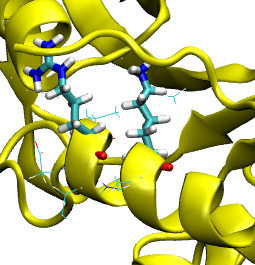
hydrophobic interaction <br />
*h*R18 -- *h*K21
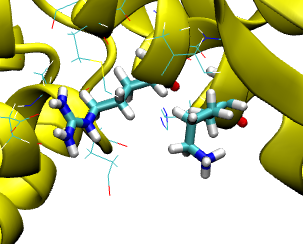
hydrophobic again <br />



## Weighted percentage per interaction

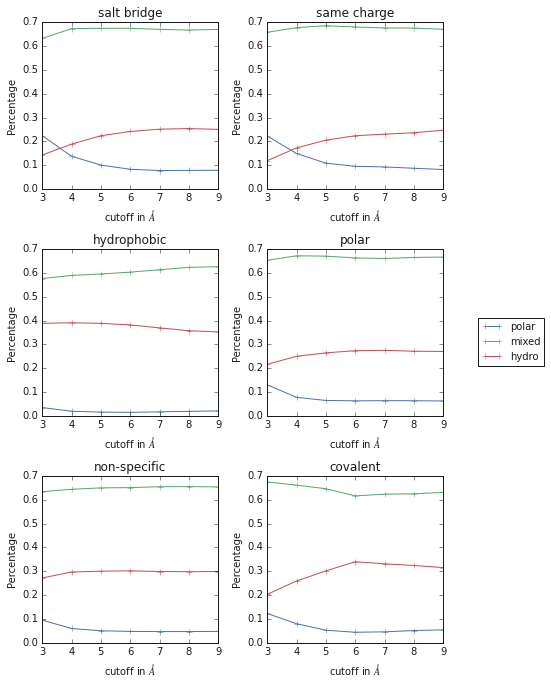

In [48]:
def dict_to_X_weighted(dict_toi, dict_net):
    X = np.zeros(7)
    for i, cutoff in enumerate(L_cutoffs):
        net = dict_net[cutoff]
        weights = np.array([net.edges()[(u, v)]['weight'] for u, v in net.edges() if (get_toi(u, v) == toi)])
        perc = np.array([dict_toi[cutoff][(u, v)] if (u, v) in dict_toi[cutoff] else np.nan for u, v in net.edges() if (get_toi(u, v) == toi)])
        try:
            masked_perc = np.ma.masked_array(perc, np.isnan(perc))
            masked_weights = np.ma.masked_array(weights, np.isnan(perc))
            X[i]=np.ma.average(masked_perc, weights=masked_weights)
        except TypeError:
            X[i] = 0
            print('TypeError')
    return X

def percentage_perdef3_weighted(dict_net, L_dict_toi, ax=None):
    Xpolar, Xmixed, Xhydro = map(dict_to_X_weighted, L_dict_toi, [dict_net]*len(L_dict_toi))
    ax.plot(L_cutoffs, Xpolar, marker='+', label='polar')
    ax.plot(L_cutoffs, Xmixed, marker='+', label='mixed')
    ax.plot(L_cutoffs, Xhydro, marker='+', label='hydro')
    ax.set_xlabel('cutoff in $\AA$')
    ax.set_ylabel('Percentage')


fig, axs = plt.subplots(3, 2, figsize=[6.4, 9.6])

for toi, ax in zip(L_interactions, axs.reshape(-1)):
    ax.set_title(toi.replace('_', ' '))
    percentage_perdef3_weighted(fullH, L_dict_toi3, ax=ax)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.2,  0.5), prop={'size': 10})
plt.tight_layout()
plt.show()
plt.close(fig) 

## Without hydrogens

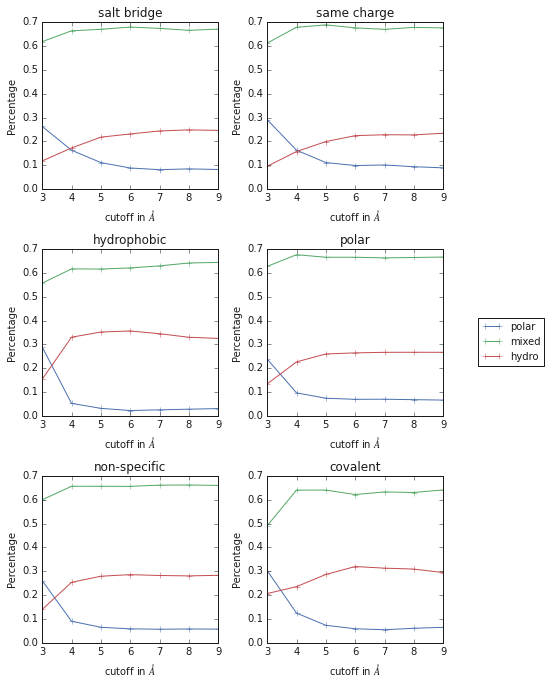

In [51]:
fig, axs = plt.subplots(3, 2, figsize=[6.4, 9.6])

for toi, ax in zip(L_interactions, axs.reshape(-1)):
    ax.set_title(toi.replace('_', ' '))
    percentage_perdef3_weighted(full, L_dict_toi3, ax=ax)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.2,  0.5), prop={'size': 10})
plt.tight_layout()
plt.show()
plt.close(fig) 

## Baker-Hubbard hbonds

In [118]:
def get_hbonds(itertraj):
    count = {}
    for chunk in itertraj:
        hbonds = md.baker_hubbard(chunk, freq=0.1)
        label = lambda hbond: (chunk.topology.atom(hbond[0]).residue.index, chunk.topology.atom(hbond[2]).residue.index)
        hbonds = np.apply_along_axis(label, -1, hbonds)
        for u, v in hbonds: 
            count[(u,v)] = count[(u,v)]+1 if (u, v) in count else 1
    return count
traj_apo = md.iterload(path_apo, top=topo, chunk=100)
traj_holo = md.iterload(path_holo, top=topo, chunk=100)

hbonds_apo = get_hbonds(traj_apo)
hbonds_holo = get_hbonds(traj_holo)

In [119]:
diff = {}
for u, v in set(hbonds_apo.keys()).union(set(hbonds_holo.keys())):
    if (u, v) in hbonds_apo and (u, v) in hbonds_holo:
        diff[(u, v)] = hbonds_apo[(u, v)] - hbonds_holo[(u, v)]
    elif (u, v) in hbonds_apo:
        diff[(u, v)] = hbonds_apo[(u, v)]
    else:
        diff[(u, v)] = -hbonds_holo[(u, v)]
        
print(diff)


{(417, 406): 0, (57, 50): -24, (449, 296): -3, (394, 348): -1, (435, 434): 4, (433, 74): 0, (130, 170): -11, (98, 45): 82, (78, 98): 0, (188, 185): 1, (333, 298): 0, (453, 296): -4, (173, 171): -23, (46, 75): 0, (373, 371): -3, (414, 413): 16, (98, 97): -42, (163, 159): 1, (248, 3): 40, (48, 77): 0, (448, 445): 0, (215, 211): 0, (336, 427): 0, (23, 19): -7, (273, 70): 1, (366, 414): 3, (50, 79): 0, (403, 400): 0, (322, 319): -5, (216, 213): 0, (236, 232): 0, (282, 280): 3, (443, 440): -6, (153, 136): -21, (308, 305): 11, (229, 40): 2, (440, 436): 0, (267, 432): -5, (86, 84): -6, (379, 407): 5, (176, 172): 3, (452, 329): -3, (20, 21): 5, (314, 310): -2, (16, 29): -8, (165, 121): -1, (98, 76): -2, (408, 407): -2, (316, 288): -5, (264, 262): 2, (187, 214): 1, (167, 196): 0, (117, 114): 18, (440, 443): -37, (125, 99): 0, (451, 448): 2, (190, 215): -1, (423, 421): -1, (291, 285): -69, (241, 237): 0, (348, 346): 0, (3, 218): 2, (161, 158): -7, (67, 71): -1, (26, 25): 15, (271, 268): -11, (45